In [1]:
import os

# Environments

In [2]:
KERNEL_TYPE = os.environ.get('KAGGLE_KERNEL_RUN_TYPE','').upper()
IS_KAGGLE = KERNEL_TYPE != ''
print('================================================')
if IS_KAGGLE:
    print(f'Notebook is running on Kaggle ({KERNEL_TYPE} mode)')
else:
    print(f'Notebook is running locally')
print('================================================')

Notebook is running on Kaggle (BATCH mode)


# Parameters and Conatants

In [3]:
DEBUG = True
DEBUG

True

In [4]:
if IS_KAGGLE:
    DATADIR = '/kaggle/input/setfit-emotion'
else:
    DATADIR = '../setfit-emotion'

TRAIN_DATA_PATH = os.path.join(DATADIR, 'train.jsonl')
VALID_DATA_PATH = os.path.join(DATADIR, 'validation.jsonl')
TEST_DATA_PATH = os.path.join(DATADIR, 'test.jsonl')

# Utilities

In [5]:
%%writefile _utils.py

import os
import json
import pandas as pd
from typing import Optional

def read_jsonl(path, st: Optional[int] = None, ed: Optional[int] = None) -> pd.DataFrame:
    record = []
    with open(path, 'r') as fp:
        for i, line in enumerate(fp.readlines()):
            if st is not None and i < st:
                continue
            if ed is not None and i > ed:
                continue
            row = json.loads(line)
            record.append(row)
    return pd.DataFrame.from_records(record)


def drop_duplicates(df: pd.DataFrame, df_ref: Optional[pd.DataFrame] = None):
    df = df.drop_duplicates('text')
    if df_ref is not None:
        index = pd.merge(df[['text']], df_ref[['text']], on='text', how='inner')['text']
        df = df.set_index('text').drop(index=index).reset_index()
    return df


def read_data(
    train_path: Optional[str] = None,
    valid_path: Optional[str] = None,
    test_path: Optional[str] = None,
):
    if train_path is not None:
        df_train = drop_duplicates(read_jsonl(train_path))
    else:
        df_train = None
    if valid_path is not None:
        df_valid = drop_duplicates(read_jsonl(valid_path), df_train)
    else:
        df_valid = None
    if test_path is not None:
        df_test = drop_duplicates(read_jsonl(test_path), df_train)
    else:
        df_valid = None
    return {'train': df_train, 'valid': df_valid, 'test': df_test}

Writing _utils.py


# Model

In [6]:
%%writefile _model.py

import torch
from transformers import DebertaV2Config, DebertaV2Model
from transformers import AutoTokenizer, DebertaV2ForSequenceClassification

LABELS = ['sadness','joy','love','anger','fear','surprise']
id2label = dict(enumerate(LABELS))
label2id = {v:k for k,v in id2label.items()}


def create_model(pretrained: str = "microsoft/deberta-v3-base"):
    # Initializing a model (with random weights) from the microsoft/deberta-v3-base style configuration
    tokenizer = AutoTokenizer.from_pretrained("microsoft/deberta-v3-base")
    model = DebertaV2ForSequenceClassification.from_pretrained(
        pretrained,
        label2id=label2id,
        id2label=id2label,
    )
    return model, tokenizer

Writing _model.py


# Dataset

In [7]:
%%writefile _dataset.py

import pandas as pd
import numpy as np
import torch


class Dataset:
    def __init__(self, df: pd.DataFrame, tokenizer, max_length: int = 512):
        self.df = df
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.df)

    def __getitem__(self, i):
        row = self.df.iloc[i]
        text = row['text']
        label = int(row['label'])
        token = self.tokenizer(text, truncation=True, padding="max_length", max_length=self.max_length)
        token = {k: np.array(v) for k, v in token.items()}
        # print(token['input_ids'])
        label = np.array(label, dtype=np.int64)
        return token, label


def collate_fn(batch):
    tokens, labels = zip(*batch)
    keys = tokens[0].keys()
    data = {k: torch.from_numpy(np.stack([token[k] for token in tokens])) for k in keys}
    data['labels'] = torch.from_numpy(np.stack(labels))
    return data

Writing _dataset.py


# Train

In [8]:
%%writefile _train.py

import os
import time
import json
import random
from dataclasses import dataclass, asdict
from typing import Optional

from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
import torch.distributed as dist
from torch.nn.parallel import DistributedDataParallel as DDP
from torch.utils.data import DataLoader
from torch.utils.data.distributed import DistributedSampler
from torch.optim import AdamW
from transformers import get_scheduler

try:
    from _dataset import Dataset, collate_fn
except:
    pass

@dataclass
class TrainConfig:
    seed: int = 0
    ddp: bool = False
    learning_rate: float = 5e-05
    train_batch_size: int = 80
    valid_batch_size: int = 80
    lr_scheduler_type: str = 'linear'
    num_epochs: int = 60
    num_warmup_steps: int = 2000//80*5
    max_train_steps: Optional[int] = None
    max_valid_steps: Optional[int] = None
    max_length: int = 512

    
def set_seed(seed=1234):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = False
    torch.backends.cudnn.benchmark = True


def train(tokenizer, model, df_train, df_valid, rank=0, world_size=0, cfg: TrainConfig = TrainConfig(), output_dir: str = './out', dry: bool = False):
    print(f"[{rank}] Starting training process.")
    os.makedirs(output_dir, exist_ok=True)
    
    if rank == 0:
        with open(os.path.join(output_dir, 'train_config.json'), 'w') as fp:
            json.dump(asdict(cfg), fp)
            
    set_seed(cfg.seed+rank)
    torch.cuda.set_device(rank)

    ds_train = Dataset(df_train, tokenizer, max_length=cfg.max_length)
    ds_valid = Dataset(df_valid, tokenizer, max_length=cfg.max_length)

    if cfg.ddp:
        train_sampler = DistributedSampler(ds_train, num_replicas=world_size, rank=rank, shuffle=True)
        valid_sampler = DistributedSampler(ds_valid, num_replicas=world_size, rank=rank, shuffle=False)
    else:
        train_sampler = None
        valid_sampler = None
        
    train_dataloader = DataLoader(ds_train, sampler=train_sampler, batch_size=cfg.train_batch_size, collate_fn=collate_fn)
    valid_dataloader = DataLoader(ds_valid, sampler=valid_sampler, batch_size=cfg.valid_batch_size, collate_fn=collate_fn, drop_last=True)

    # Model
    model = model.to(rank)
    if cfg.ddp:
        model = DDP(model, device_ids=[rank])

    optimizer = AdamW(model.parameters(), lr=cfg.learning_rate)
    lr_scheduler = get_scheduler(
        cfg.lr_scheduler_type,
        optimizer=optimizer,
        num_warmup_steps=cfg.num_warmup_steps,
        num_training_steps=min(len(train_dataloader),cfg.max_train_steps or len(train_dataloader))*cfg.num_epochs+1
    )

    records = []
    best_loss = None
    
    for epoch in range(1, cfg.num_epochs+1):
        st = time.time()
        step = 1
        train_loss = 0

        model.train()
        for batch in tqdm(train_dataloader, disable=rank!=0):
            lr_scheduler.step()
            lr = lr_scheduler.get_last_lr()[0]
            if dry:
                continue
            batch = {k: v.to(rank) for k, v in batch.items()}
            outputs = model(**batch)
            loss = outputs.loss
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            train_loss = loss.item()
            if cfg.max_train_steps is not None and step >= cfg.max_train_steps:
                break
            step += 1

        valid_loss = 0
        valid_accuracy = 0
        cnt = 0
        step = 1
        
        model.eval()
        with torch.no_grad():
            for batch in tqdm(valid_dataloader, disable=rank!=0):
                cnt += 1
                if dry:
                    continue
                batch = {k: v.to(rank) for k, v in batch.items()}
                outputs = model(**batch)
                loss = outputs.loss
                valid_loss += loss.item()
                # score: accuracy
                pred = torch.argmax(F.softmax(outputs.logits), dim=1)
                valid_accuracy += torch.mean((pred == batch['labels']).float()).item()
                step += 1
                if cfg.max_valid_steps is not None and step >= cfg.max_valid_steps:
                    break
            valid_loss /= cnt
            valid_accuracy /= cnt
            
        if rank == 0:
            dt = time.time() - st
            records.append({
                'epoch': epoch,
                'lr': lr,
                'train_loss': train_loss,
                'valid_loss': valid_loss,
                'valid_accuracy': valid_accuracy
            })
            print(f"[{epoch}/{cfg.num_epochs}] Train Loss: {train_loss:.4f} Valid Loss: {valid_loss:.4f} Accuracy: {valid_accuracy:.4f} Cost: {dt} s")
            if best_loss is None or valid_loss < best_loss:
                best_loss = valid_loss
                # save model
                print('Save model')
                save_path = os.path.join(output_dir, 'best')
                if cfg.ddp:
                    model.module.save_pretrained(save_path)
                else:
                    model.save_pretrained(save_path)
    
    if rank == 0:
        # save last
        save_path = os.path.join(output_dir, 'last')
        if cfg.ddp:
            model.module.save_pretrained(save_path)
        else:
            model.save_pretrained(save_path)
        # save training log
        df_log = pd.DataFrame.from_records(records)
        df_log.to_csv(os.path.join(output_dir, 'train_log.csv'), index=False)

Writing _train.py


# Main Script

In [9]:
%%writefile main.py

import os
import random
import time
import numpy as np
import torch
import torch.distributed as dist

try:
    from _model import create_model
    from _train import train, TrainConfig
    from _utils import read_data
except:
    pass


def setup(rank, world_size):
    torch.cuda.set_device(rank)
    dist.init_process_group("nccl", rank=rank, world_size=world_size)
    return


def main(rank: int = 0, world_size: int = 1, debug: bool = False, dry: bool = False):
    """
    Deberta:
    - max_length: 72, batch_size: 128
    - max_length: 512, batch_size: 8
    DebertaV2:
    - max_length: 72, batch_size: 80 (13.7GB)
    - max_length: 512, batch_size: 8 (11.5GB)
    """
    common = dict(
        seed=567,
        max_length=72,
        train_batch_size=80,
        valid_batch_size=80,
    )
    if debug:
        cfg = TrainConfig(ddp=True, num_epochs=2, max_train_steps=2, max_valid_steps=2, **common)
    else:
        cfg = TrainConfig(ddp=True, num_epochs=20, **common)

    if cfg.ddp:
        setup(rank, world_size)
        time.sleep(rank)
        _, total = torch.cuda.mem_get_info(device=rank)
        print(f"Rank: {rank}, World size: {world_size}, GPU memory: {total / 1024**3:.2f}GB", flush=True)
        time.sleep(world_size - rank)

    datadir = '/kaggle/input/setfit-emotion/'
    data_dict = read_data(
        os.path.join(datadir, 'train.jsonl'),
        os.path.join(datadir, 'validation.jsonl'),
        os.path.join(datadir, 'test.jsonl'),
    )
    df_train = data_dict['train']
    df_valid = data_dict['valid']
    df_test = data_dict['test']

    try:
        model, tokenizer = create_model()
        train(tokenizer, model, df_train, df_valid, rank=rank, world_size=world_size, cfg=cfg, dry=dry)
    finally:
        if cfg.ddp:
            cleanup()


def cleanup():
    dist.barrier()
    dist.destroy_process_group()
    return


if __name__ == "__main__":
    # GPU Specs
    rank = int(os.environ.get("RANK", 0))
    world_size = int(os.environ.get("WORLD_SIZE", 1))

    # Run
    KERNEL_TYPE = os.environ.get('KAGGLE_KERNEL_RUN_TYPE','').upper()
    print(KERNEL_TYPE)
    # main(rank, world_size, debug=False, dry=True)
    main(rank, world_size, debug=KERNEL_TYPE != 'BATCH')

Writing main.py


# Run

In [10]:
!OMP_NUM_THREADS=1 torchrun --nproc_per_node=2 main.py

2025-05-30 00:47:59.255320: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-05-30 00:47:59.255312: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748566079.493434      42 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748566079.493420      41 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748566079.561167      41 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
E0000 00:00:1748566079.561196      42 cuda_blas.cc:1

    epoch            lr  train_loss  valid_loss  valid_accuracy
0       1  4.000000e-05    0.690887    0.608982        0.808333
1       2  4.800107e-05    0.329872    0.196410        0.923958
2       3  4.533582e-05    0.198896    0.139363        0.940625
3       4  4.267058e-05    0.126459    0.114950        0.948958
4       5  4.000533e-05    0.093160    0.119771        0.946875
5       6  3.734009e-05    0.082741    0.136230        0.937500
6       7  3.467484e-05    0.076050    0.164536        0.939583
7       8  3.200959e-05    0.057310    0.167306        0.934375
8       9  2.934435e-05    0.063255    0.168311        0.943750
9      10  2.667910e-05    0.084366    0.194736        0.944792
10     11  2.401386e-05    0.016172    0.183084        0.941667
11     12  2.134861e-05    0.037120    0.210839        0.947917
12     13  1.868337e-05    0.021857    0.222741        0.940625
13     14  1.601812e-05    0.004592    0.258355        0.940625
14     15  1.335288e-05    0.009412    0

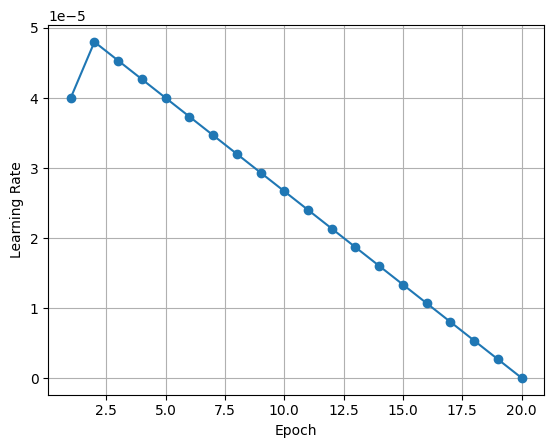

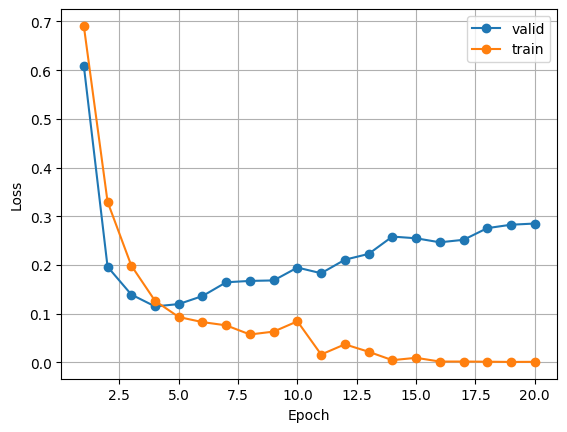

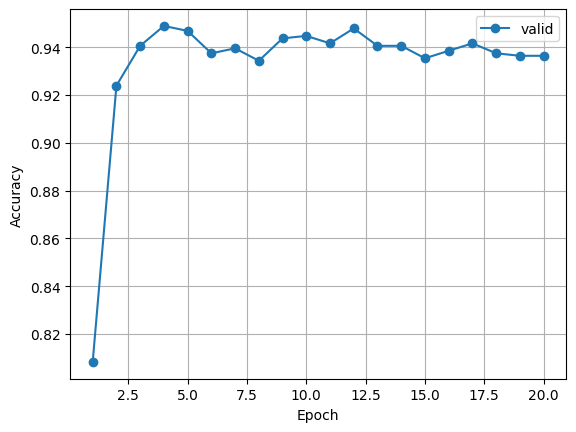

In [11]:
import os
import pandas as pd
import matplotlib.pyplot as plt

df_log_path = '/kaggle/working/out/train_log.csv'

if os.path.exists(df_log_path):
    df_log = pd.read_csv(df_log_path)
    print(df_log)
    # draw training log
    plt.plot(df_log['epoch'], df_log['lr'], '-o')
    plt.xlabel('Epoch')
    plt.ylabel('Learning Rate')
    plt.grid()
    plt.show()
        
    plt.plot(df_log['epoch'], df_log['valid_loss'], '-o', label='valid')
    plt.plot(df_log['epoch'], df_log['train_loss'], '-o', label='train')
    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid()
    plt.show()
    
    plt.plot(df_log['epoch'], df_log['valid_accuracy'], '-o', label='valid')
    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.grid()
    plt.show()
        